In [3]:
import torch
import numpy as np
import cv2
from tifffile import imread
from scipy.ndimage import zoom
from skimage.segmentation import watershed
from scipy.ndimage import label as ndi_label
from skimage.feature import peak_local_max
from skimage.morphology import h_maxima
import sys

sys.path.insert(0, "../utils")

from utils.predict_by_parts import predict_by_parts
from norm_percentile_nocrop import norm_percentile_nocrop

# Load the timage and model

In [4]:
device = torch.device("cpu")
model = torch.load("detection_model.pt", map_location=torch.device("cpu"))
folder_name_to_evaluate = "../../data_zenodo/NHDF/NHDF_8h PI/IR 0,5Gy_8h PI/0001"

detection_channel = 2  # red 0, green 1, red and green 2
resized_img_size = [505, 681, 48]  # image is resized to this size
normalization_percentile = 0.0001  # image is normalized into this percentile range
crop_size = [96, 96]

In [5]:
img_filename = folder_name_to_evaluate + "/data_53BP1.tif"
img = []
img.append(imread(img_filename))  # red
img.append(imread(img_filename.replace("53BP1", "gH2AX")))  # green
img.append(imread(img_filename.replace("53BP1", "DAPI")))  # DAPI

img = np.stack(img, axis=3)

print(img.shape)

img_orig_size = img.shape[:3]
factor = np.array(resized_img_size) / np.array(img_orig_size)

tmp_size = resized_img_size.copy()
tmp_size.append(img.shape[3])
img_resized = np.zeros(tmp_size, dtype=np.float32)

for channel in range(img.shape[3]):
    data_one_channel = img[..., channel]
    data_one_channel = zoom(data_one_channel, factor, order=1)
    data_one_channel = norm_percentile_nocrop(
        data_one_channel, normalization_percentile
    )
    img_resized[..., channel] = data_one_channel

img = img_resized
img = img.astype(np.float32)
img = np.transpose(img, (3, 0, 1, 2)).copy()
img = torch.from_numpy(img)

print(img.shape)


(1010, 1362, 50, 3)
torch.Size([3, 505, 681, 48])


In [11]:
img = img.to(device)

res = predict_by_parts(model, img, crop_size=crop_size)

img = img.detach().cpu().numpy()
res = res.detach().cpu().numpy()

100%|██████████| 63/63 [01:01<00:00,  1.02it/s]


In [28]:
from skimage import filters, morphology, segmentation
from skimage import measure  # needed for labeling
import numpy as np
import imageio

def save_mask_gif(base_img, mask, gif_name, duration=1000):
    """
    base_img: HxW, float in [0,1] → red channel
    mask:     HxW, float in [0,1] → blue channel (no threshold)
    """
    base = np.clip(base_img, 0.0, 1.0).astype(np.float32)
    mask_f = np.clip(mask, 0.0, 1.0).astype(np.float32)

    base_rgb = np.zeros((*base.shape, 3), dtype=np.uint8)
    base_rgb[..., 0] = (base * 255).astype(np.uint8)   # red

    model_rgb = base_rgb.copy()
    model_rgb[..., 2] = (mask_f * 255).astype(np.uint8) # blue

    frames = [base_rgb, model_rgb]  # single overlay frame duplicated
    imageio.mimsave(gif_name, frames, duration=duration, loop=0)
    return gif_name

def foci_mask(
    img,
    min_size=10,
    max_size=100,
    sigma=0.25,
    peak_min_distance=2,
    watershed_line=True,
):
    v_blur = filters.gaussian(img, sigma=sigma)
    thresh = filters.threshold_yen(v_blur)
    mask = img > thresh

    peaks = peak_local_max(
        v_blur,
        min_distance=int(np.round(peak_min_distance)),
        threshold_abs=thresh,
        footprint=np.ones((3, 3))
    )
    markers = np.zeros_like(mask, dtype=np.int32)
    if peaks.size:
        markers[tuple(peaks.T)] = 1
    markers, _ = ndi_label(markers)
    labels_ws = segmentation.watershed(-v_blur, markers=markers, mask=mask, watershed_line=watershed_line)
    mask = labels_ws > 0

    mask = morphology.remove_small_objects(mask, min_size=min_size)

    if max_size is not None:
        labels = measure.label(mask)
        sizes = np.bincount(labels.ravel())
        large_labels = np.where(sizes > max_size)[0]
        if large_labels.size:
            mask[np.isin(labels, large_labels)] = False  # drop overly large components

    selem = morphology.disk(1)
    mask = morphology.binary_closing(mask, selem)
    mask = segmentation.clear_border(mask)
    return mask

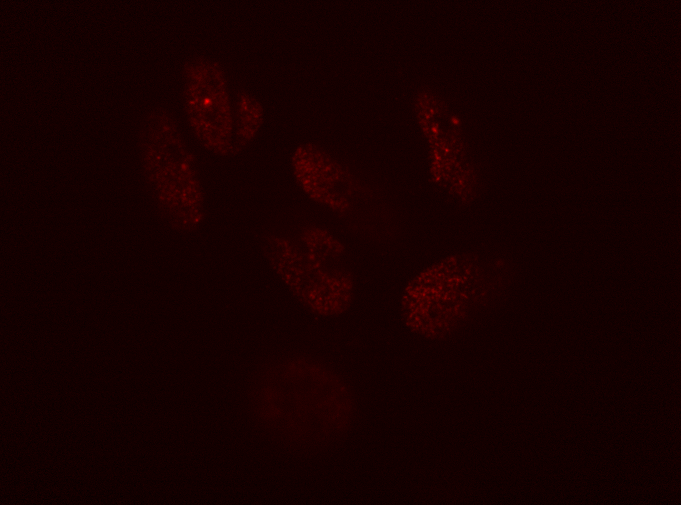

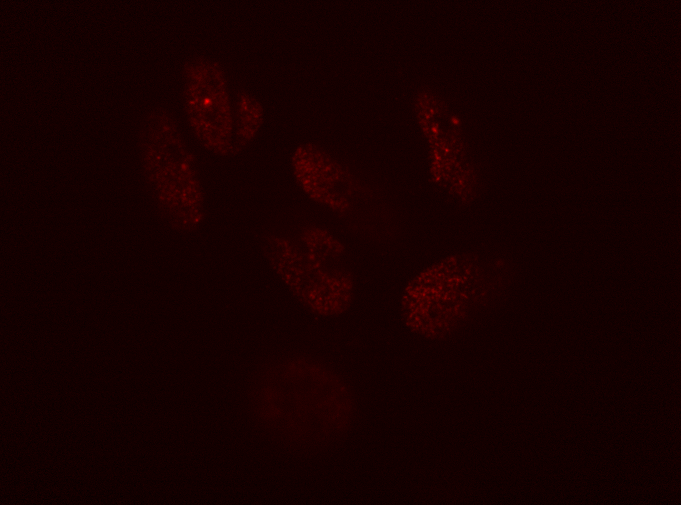

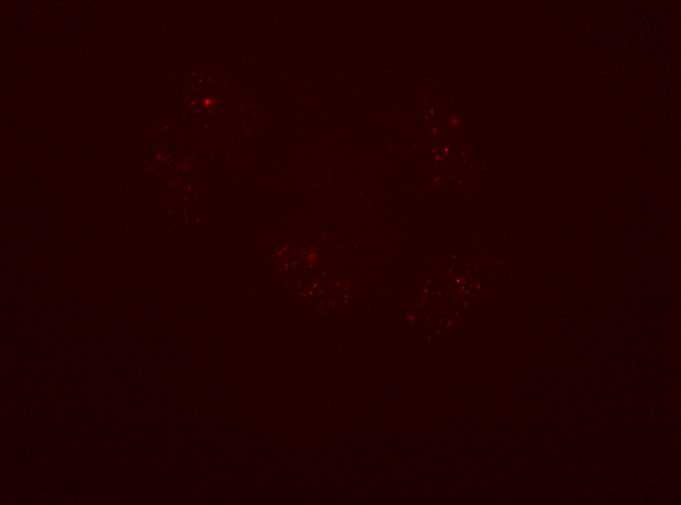

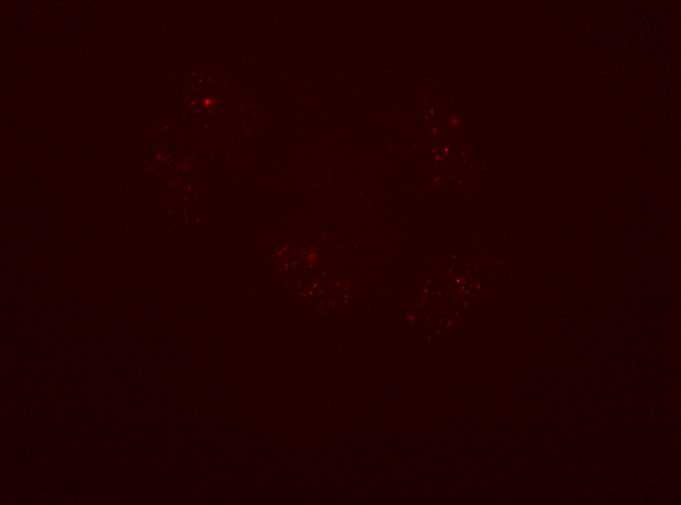

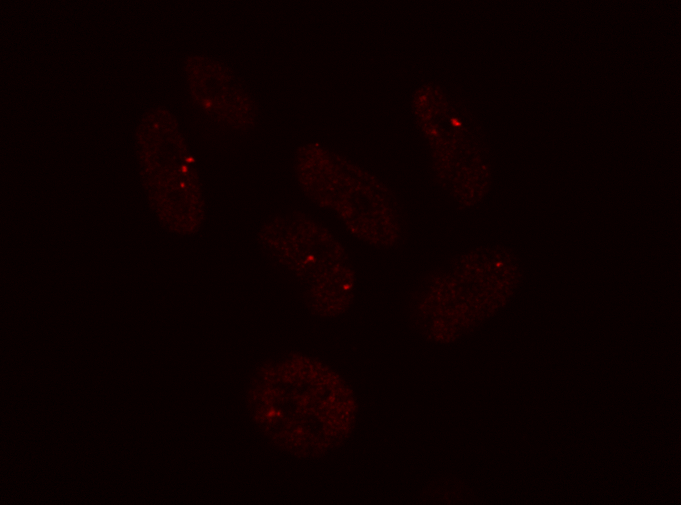

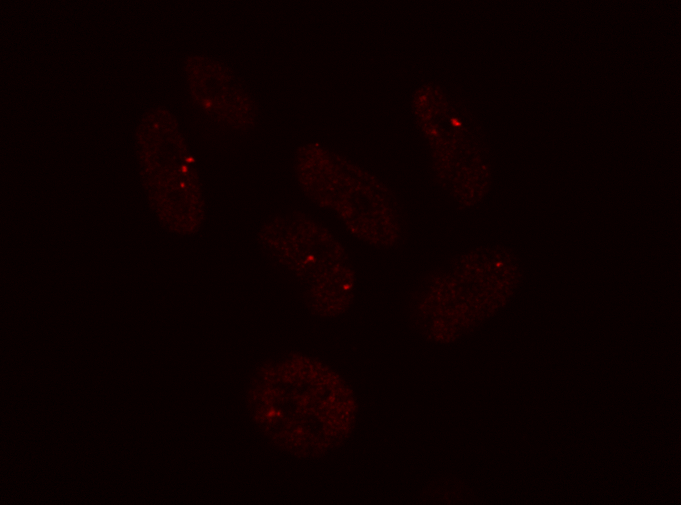

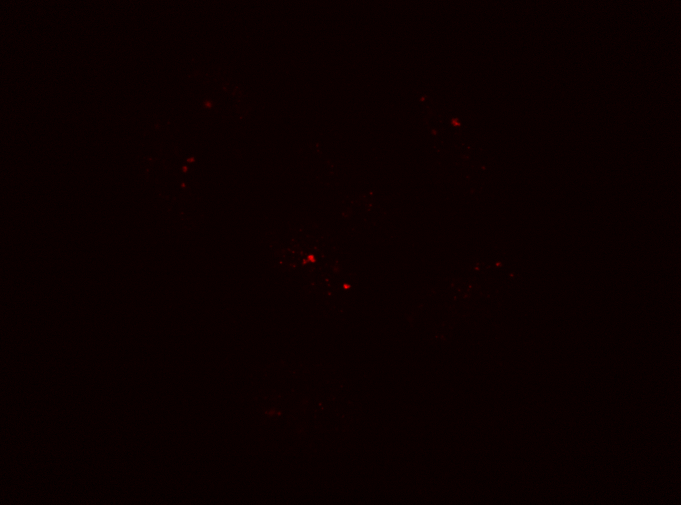

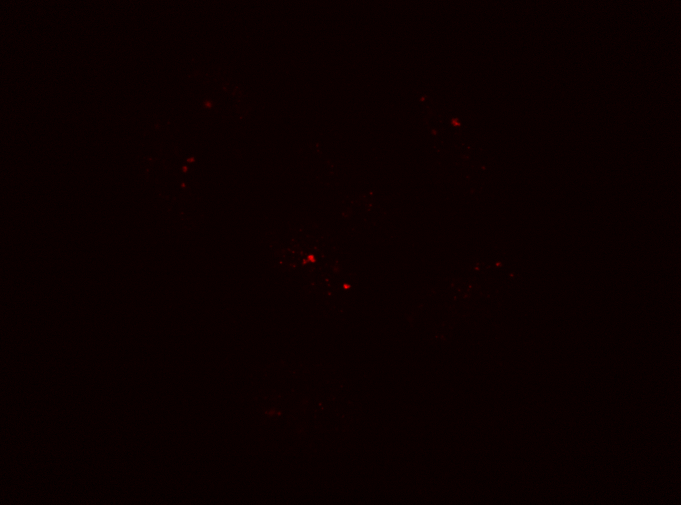

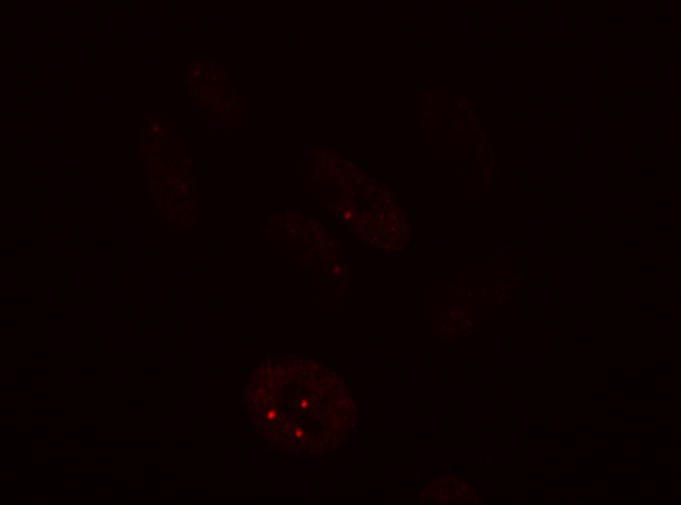

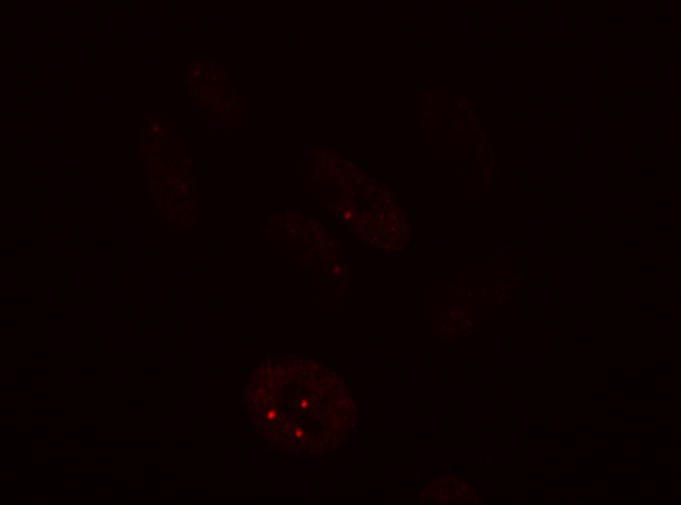

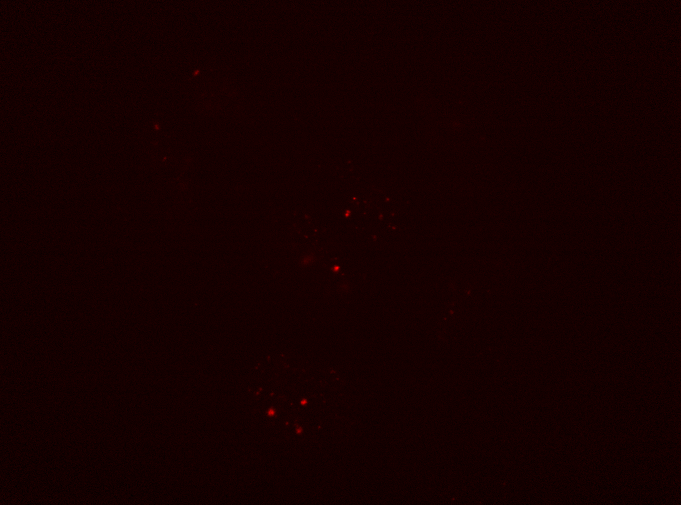

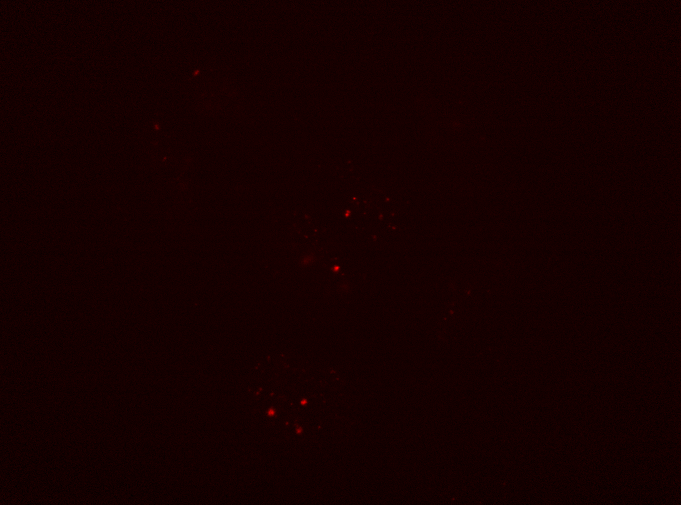

In [61]:
from itertools import product
from IPython.display import Image, display

slices = [15, 20, 25]
channels = [0, 1]

for slice_idx, channel in list(product(slices, channels)):
    img_select = img[channel, :, :, slice_idx]
    img_norm = (img_select - img_select.min()) / (img_select.ptp() + 1e-8)

    res_select = res[channel, :, :, slice_idx]
    res_norm = (res_select - res_select.min()) / (res_select.ptp() + 1e-8)
    classical_mask = foci_mask(img_norm, sigma=0.25)
    net_mask = foci_mask(res_norm, sigma=0.25)

    classical_file = save_mask_gif(img_norm, classical_mask, f"class_{slice_idx}_{channel}.gif")
    net_file = save_mask_gif(img_norm, net_mask, f"res_{slice_idx}_{channel}.gif")
    display(Image(filename=classical_file))
    display(Image(filename=net_file))

In [43]:
from itertools import product
from IPython.display import Image, display

slices = range(0, img.shape[3])
channels = [0, 1]
masks = {
    0: [],
    1: []
}
for slice_idx, channel in list(product(slices, channels)):
    img_select = img[channel, :, :, slice_idx]
    img_norm = (img_select - img_select.min()) / (img_select.ptp() + 1e-8)
    masks[channel].append(foci_mask(img_norm, sigma=0.25))

In [62]:
masks[0] = np.array(masks[0])
masks[1] = np.array(masks[1])

labels = {}
for c in [0, 1]:
    mask_vol = masks[c].astype(bool)
    labels[c] = measure.label(mask_vol, connectivity=1)

In [63]:
img.shape, masks[1].shape, masks[0].shape

((3, 505, 681, 48), (48, 505, 681), (48, 505, 681))

In [71]:
path = "../../data_zenodo/NHDF/NHDF_8h PI/IR 0,5Gy_8h PI/0001/nuclei_mask.npy"

nuclei_mask = np.load(path)
resized_img_size = [505, 681, 48]  # image is resized to this size
img_orig_size = nuclei_mask.shape
factor = np.array(resized_img_size) / np.array(img_orig_size)
nuclei_mask = zoom(nuclei_mask, factor, order=0)

In [74]:
from skimage.color import label2rgb

slices_selected = range(12, 28)
channels = [0, 1]

for c in channels:
    frames = []
    for z in slices_selected:
        img_select = img[c, :, :, z]
        img_norm = (img_select - img_select.min()) / (img_select.ptp() + 1e-8)
        lbl = labels[c][z, :, :]            # 2D labels
        nuc = nuclei_mask[:, :, z] > 0      # nuclei mask slice

        left = np.zeros((*img_select.shape, 3), dtype=np.float32)
        if c == 0:
            left[..., 0] = img_norm  # red
        else:
            left[..., 1] = img_norm  # green

        right = label2rgb(lbl, bg_label=0, bg_color=(0, 0, 0))
        right[(lbl == 0) & nuc] = (1.0, 1.0, 1.0)  # nuclei as white background

        frame = np.concatenate([left, right], axis=1)
        frame_uint8 = (np.clip(frame, 0, 1) * 255).astype(np.uint8)

        cv2.putText(frame_uint8, f"z={z}", (10, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1, cv2.LINE_AA)
        frames.append(frame_uint8)

    gif_name = f"foci_labels_with_nuclei_{'red' if c == 0 else 'green'}.gif"
    imageio.mimsave(gif_name, frames, duration=500, loop=0)